### Trainer
---

In this file, we're going to take in the rash data, tokenize it, and train a simple MLP on it to see how it'll do. If it works, then we can develop a flask app to serve the model and build out the frontend. For now, the goal is two-class classification (EM positive or negative).


In [2]:
# IMPORTS
# ------------ 

import open_clip # For the tokenizer
import pandas as pd # To store image data
import torch 
import numpy as np 
import keras
import tensorflow as tf
from keras.models import Sequential # MLP model
from keras.layers import Dropout, Dense # Layers for the model
from scikeras.wrappers import KerasClassifier # Wrapper for the model
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score # Metrics
from sklearn.metrics import confusion_matrix # For confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt # For plotting
import os # General OS operations
from PIL import Image  # For image processing
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')


print("All imports successful.")

/home/kodur/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-16 13:57:01.941372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 13:57:01.954985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 13:57:01.958818: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 13:57:01.970066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optim

All imports successful.


/home/kodur/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [13]:

# LOADING TOKENIZER AND MODEL
# ------------ 

CLIP_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32',
                                            pretrained = 'laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
print("Tokenizer initialized.")

Tokenizer initialized.


In [4]:
# GETTING DATA
# ------------ 

# Define relevant dataframes
data_train = pd.DataFrame()
data_test = pd.DataFrame()

# Upload positive and negative examples, add var to keep track of class
TRAIN_PATH_POS = "./data/train/positive/"
TRAIN_PATH_NEG = "./data/train/negative/"
data_train = pd.concat([data_train, pd.DataFrame({
            'filename': os.listdir(TRAIN_PATH_POS), 
            'class': 1})]) 
data_train = pd.concat([data_train, pd.DataFrame({
            'filename': os.listdir(TRAIN_PATH_NEG), 
            'class': 0})])

# Repating process for the validation data
TEST_PATH_POS = "./data/val/positive/"
TEST_PATH_NEG = "./data/val/negative/"
data_test = pd.concat([data_test, pd.DataFrame({
            'filename': os.listdir(TEST_PATH_POS), 
            'class': 1})])
data_test = pd.concat([data_test, pd.DataFrame({
            'filename': os.listdir(TEST_PATH_NEG), 
            'class': 0})])

# Print heads of the dataframes to check if everything is correct
print('--------------TRAIN----------------- ')
print(data_train.head())
print('--------------TEST------------------ ')
print(data_test.head())
print('------------------------------------ ')
print("Data loaded successfully.")

--------------TRAIN----------------- 
                  filename  class
0  erythema migrans174.jpg      1
1  erythema migrans175.jpg      1
2  erythema migrans152.jpg      1
3   erythema migrans70.jpg      1
4  erythema migrans136.jpg      1
--------------TEST------------------ 
                 filename  class
0  erythema migrans33.jpg      1
1  erythema migrans35.jpg      1
2  erythema migrans42.jpg      1
3  erythema migrans17.jpg      1
4  erythema migrans44.jpg      1
------------------------------------ 
Data loaded successfully.


In [14]:
# GENERATING EMBEDDINGS
# ------------

def generate_embedding(filepath):

    # Load image
    image = preprocess(Image.open(filepath)).unsqueeze(0)
    with torch.no_grad():

        # Generate embedding and flatten them
        image_features = CLIP_model.encode_image(image)
        image_features = image_features.view(-1)

    return image_features

# Generate embeddings for all images in the training set
# We can iterate through the dataframe and generate embeddings for each image
# Normally you don't want to iterate through a dataframe but whatever.

train_embeddings = []

for index, row in data_train.iterrows():
    filename = row['filename']
    class_type = row['class']
    filepath = TRAIN_PATH_POS if class_type else TRAIN_PATH_NEG
    filepath += filename

    # Generate embedding
    embedding = generate_embedding(filepath)
    train_embeddings.append(embedding)


test_embeddings = []
for index, row in data_test.iterrows():
    filename = row['filename']
    class_type = row['class']
    filepath = TEST_PATH_POS if class_type else TEST_PATH_NEG
    filepath += filename

    # Generate embedding
    embedding = generate_embedding(filepath)
    test_embeddings.append(embedding)


# Convert embeddings to numpy arrays and add them to the dataframes
train_embeddings = torch.stack(train_embeddings).numpy()
data_train['embedding'] = list(train_embeddings)

test_embeddings = torch.stack(test_embeddings).numpy()
data_test['embedding'] = list(test_embeddings)


In [7]:
# DEFINE MLP MODEL
# ------------

def create_model():
    model = Sequential()
    model.add(Dense(512, input_dim=512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(), keras.metrics.F1Score()])
    return model


In [45]:
# TRAINING THE MODEL
# ------------

train_X = np.stack(data_train['embedding'].values)
train_y = np.stack(data_train['class'].values)

model = KerasClassifier(model = create_model, batch_size=32, 
                                    epochs=150, verbose = 1)
model.fit(train_X, train_y)

Epoch 1/50


/home/kodur/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc_2: 0.5486 - f1_score: 0.5820 - loss: 0.7446  
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.6461 - f1_score: 0.6058 - loss: 0.6855 
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.7140 - f1_score: 0.6069 - loss: 0.6261 
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.8183 - f1_score: 0.6155 - loss: 0.5410 
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.8817 - f1_score: 0.5634 - loss: 0.4356 
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.8592 - f1_score: 0.5808 - loss: 0.4756 
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.9266 - f1_score: 0.5806 - loss: 0.3575 
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.9388 - f1_score: 0.5997 - loss: 0.3193 
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.9558 - f1_score: 0.5875 - loss: 0.2658 
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc_2: 0.9481 - f1_score: 0.6064 - loss: 0.3170 

KerasClassifier(
	model=<function create_model at 0x7ff1c0e695a0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	class_weight=None
)

In [46]:
# EVALUATING THE MODEL
# ------------

test_X = np.stack(data_test['embedding'].values)
test_y = np.stack(data_test['class'].values)

model.score(test_X, test_y)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


0.8620689655172413

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


F1 Score: 0.8666666666666667
ROC AUC Score: 0.8823529411764706
Accuracy: 0.9090909090909091


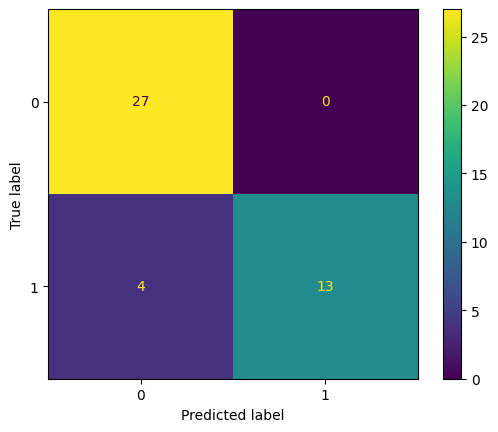

In [52]:
# ANALYTICS
# ------------

# Print out F1 score, ROC AUC score, and accuracy
y_pred = model.predict(test_X)
print(f"F1 Score: {f1_score(test_y, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(test_y, y_pred)}")
print(f"Accuracy: {accuracy_score(test_y, y_pred)}")

# Plot confusion matrix
cm = confusion_matrix(test_y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


F1 Score: 0.8275862068965517
ROC AUC Score: 0.8801843317972351
Accuracy: 0.8888888888888888
-----------------------------------------------
F1 Score: 0.7878787878787878
ROC AUC Score: 0.8372844827586207
Accuracy: 0.8444444444444444
-----------------------------------------------


F1 Score: 0.8
ROC AUC Score: 0.825098814229249
Accuracy: 0.8222222222222222
-----------------------------------------------
F1 Score: 0.8
ROC AUC Score: 0.8248987854251012
Accuracy: 0.8222222222222222
-----------------------------------------------
F1 Score: 0.8095238095238095
ROC AUC Score: 0.8181818181818181
Accuracy: 0.8181818181818182
-----------------------------------------------
F1 Score: 0.8648648648648649
ROC AUC Score: 0.8965141612200436
Accuracy: 0.8863636363636364
-----------------------------------------------
F1 Score: 0.7222222222222222
ROC AUC Score: 0.764957264957265
Accuracy: 0.7727272727272727
-----------------------------------------------
F1 Score: 0.8205128205128205
ROC AUC Score: 0.8410526315789473
Accuracy: 0.8409090909090909
-----------------------------------------------
F1 Score: 0.85
ROC AUC Score: 0.8612836438923396
Accuracy: 0.8636363636363636
-----------------------------------------------
F1 Score: 0.8387096774193549
ROC AUC Score: 0.8611111111111112
Acc

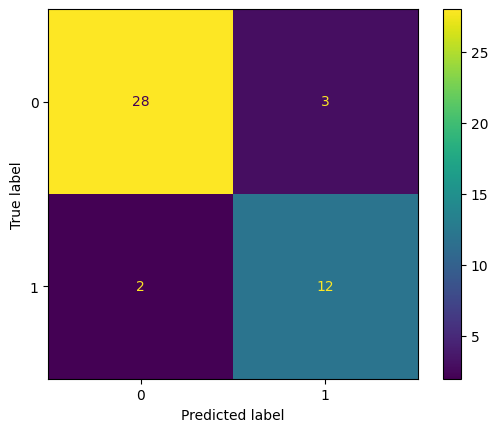

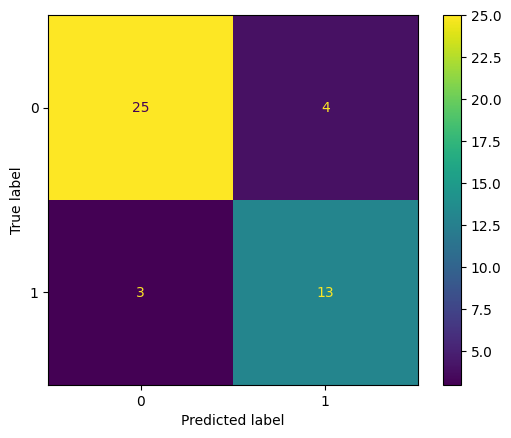

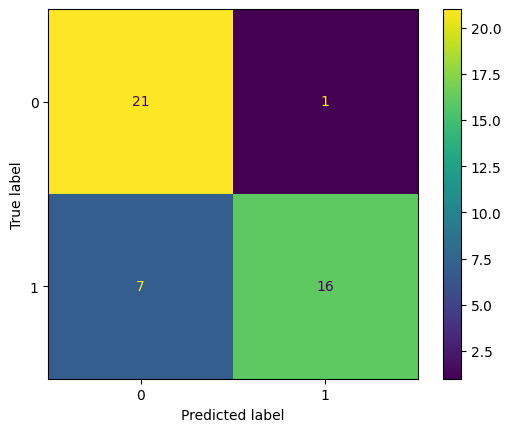

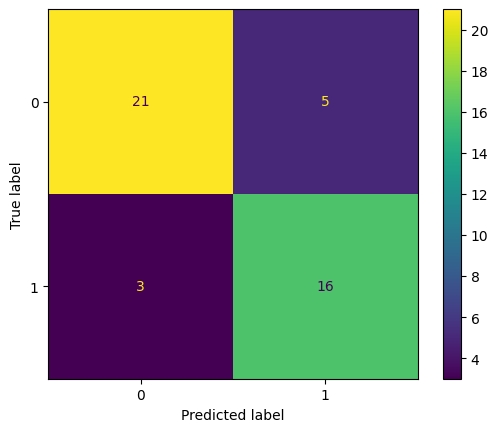

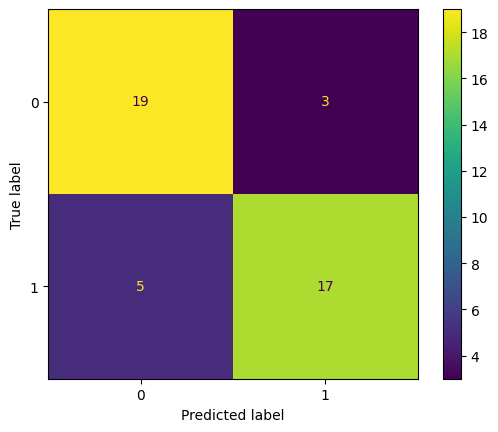

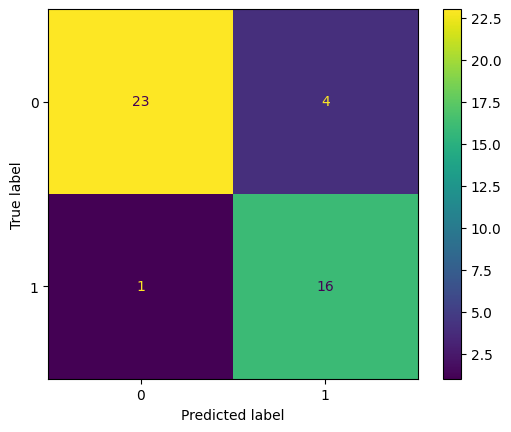

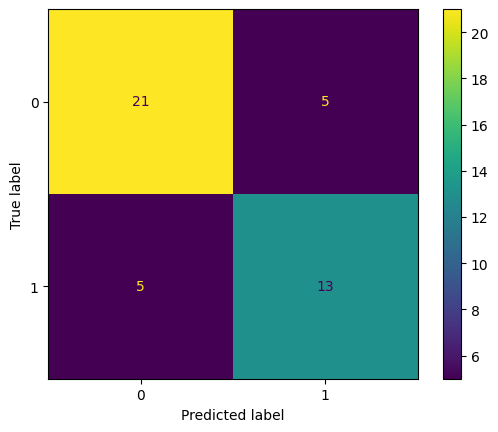

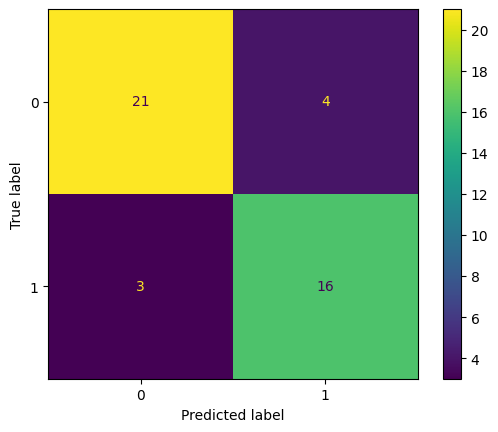

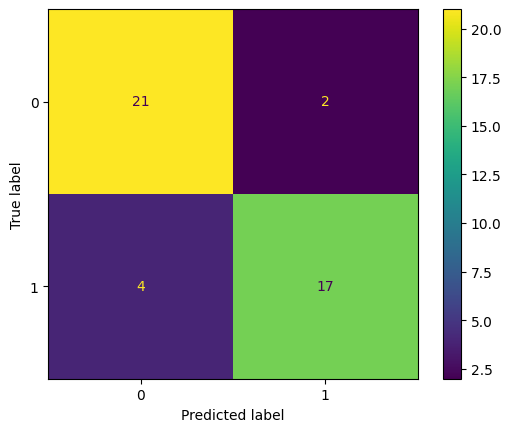

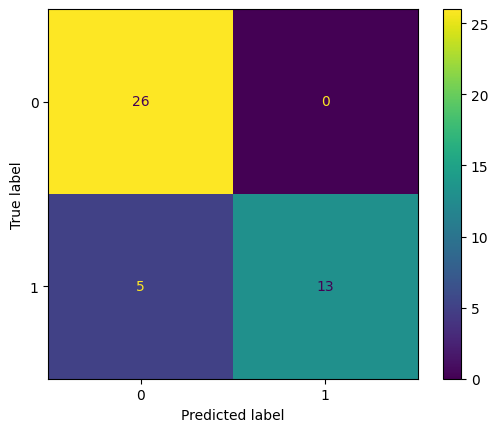

In [8]:
# K-FOLD CROSS VALIDATION
# ------------

# Since the dataset is so small, let's also try doing K-Fold Cross Validation
# We first need to combine the train and test data

all_data = pd.concat([data_train, data_test])

# Define the K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True)

for train, test in kf.split(all_data):
    train_data = all_data.iloc[train]
    test_data = all_data.iloc[test]

    train_X = np.stack(train_data['embedding'].values)
    train_y = np.stack(train_data['class'].values)

    test_X = np.stack(test_data['embedding'].values)
    test_y = np.stack(test_data['class'].values)

    model = KerasClassifier(model = create_model, batch_size=32, 
                                    epochs=15, verbose = 0)
    model.fit(train_X, train_y)

    y_pred = model.predict(test_X)
    print(f"F1 Score: {f1_score(test_y, y_pred)}")
    print(f"ROC AUC Score: {roc_auc_score(test_y, y_pred)}")
    print(f"Accuracy: {accuracy_score(test_y, y_pred)}")
    print('-----------------------------------------------')
    cm = confusion_matrix(test_y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


In [9]:
# TRAINING EXPORT MODEL
# ------------

# Since k-fold validation did well, train an export model 
# on the entire dataset.

all_X = np.stack(all_data['embedding'].values)
all_y = np.stack(all_data['class'].values)


export_model = Sequential()
export_model.add(Dense(512, input_dim=512, activation='relu'))
export_model.add(Dropout(0.5))
export_model.add(Dense(256, activation='relu'))
export_model.add(Dropout(0.5))
export_model.add(Dense(128, activation='relu'))
export_model.add(Dropout(0.5))
export_model.add(Dense(1, activation='sigmoid'))
export_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC()])

export_model.fit(tf.cast(all_X, tf.float32), tf.cast(all_y, tf.float32), batch_size=32, epochs=300, verbose=0)

In [64]:
# EXPORTING FINAL MODEL
# ------------

export_model.save('./models/export_model.keras')

In [25]:
# TEST MODEL ON LENNA.PNG
# NOTE: This will obviously not produce an accurate result, because
# this image isn't related to our domain of interest.
# ------------

# Load image
image = preprocess(Image.open('./data/LENNA.png')).unsqueeze(0)

print(image.shape)
# Generate embedding and flatten them
image_features = CLIP_model.encode_image(image)

print(image_features.shape)
# Predict
print(export_model.predict(image_features.detach().numpy()))

torch.Size([1, 3, 224, 224])
torch.Size([1, 512])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.99999994]]
